[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 26
[LightGBM] [Info] Start training from score 0.482130


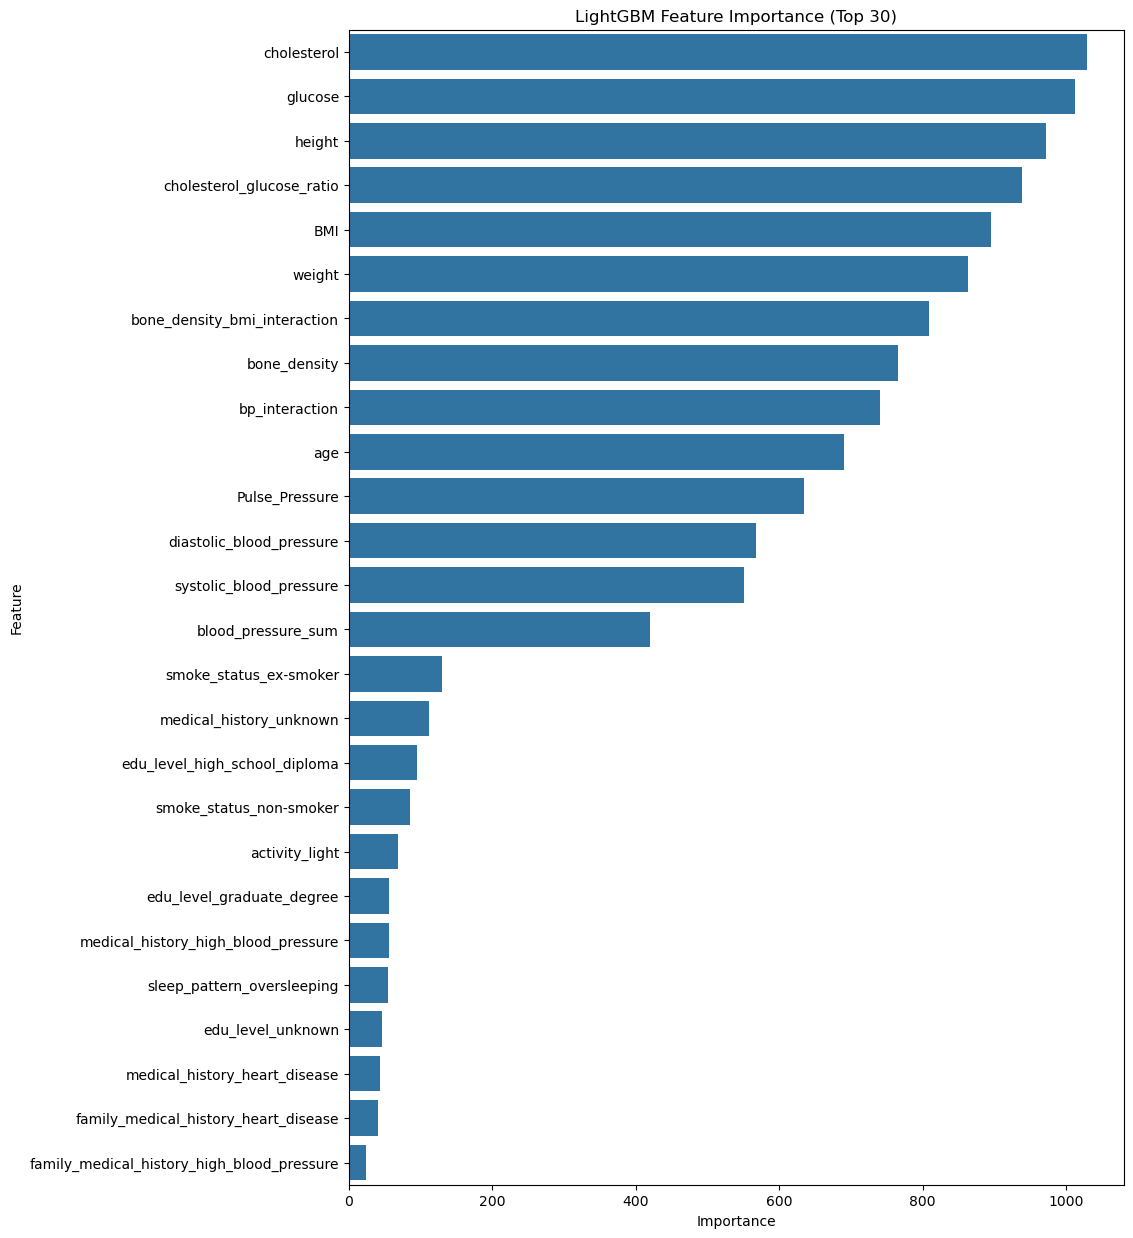

c:\Users\rladud\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rladud\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rladud\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rladud\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\rladud\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(

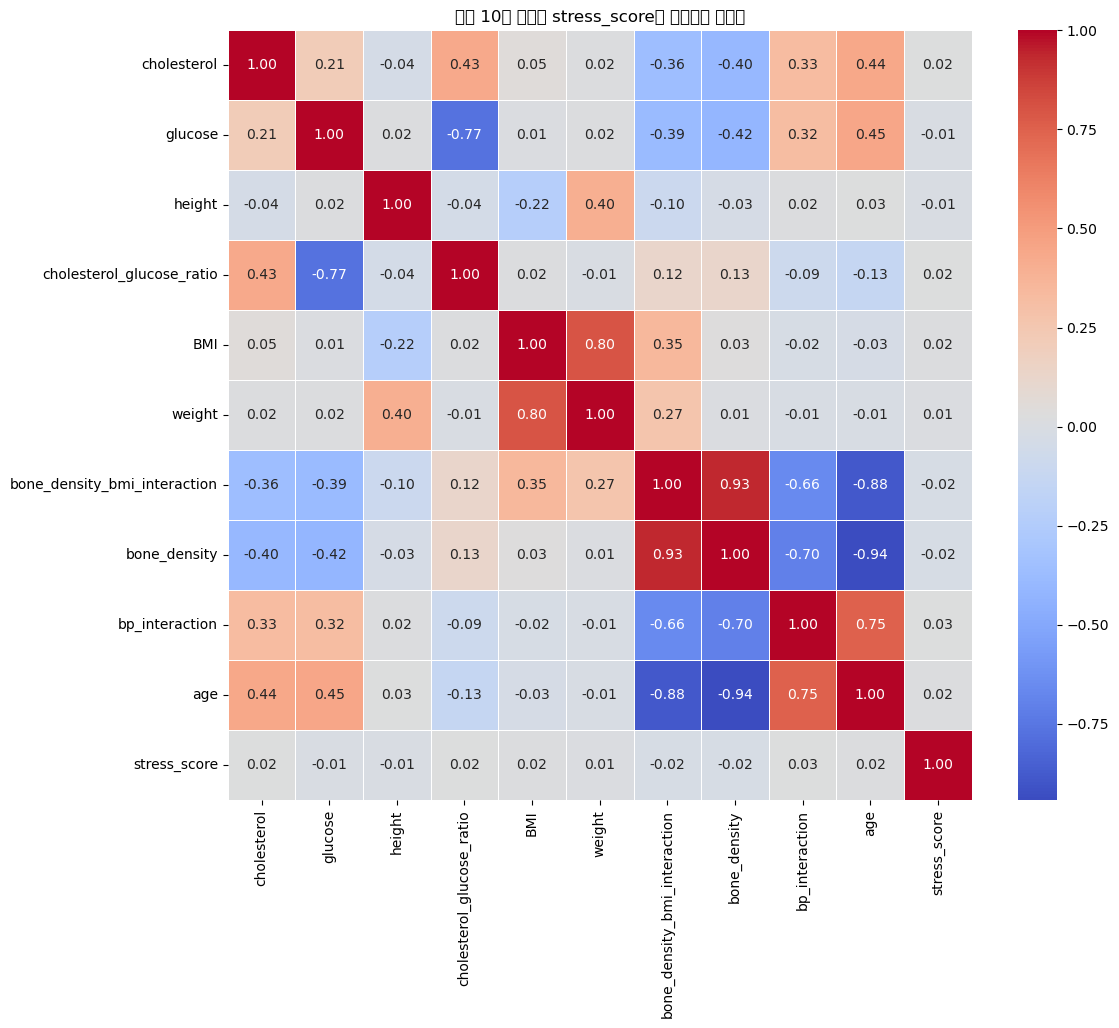

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 1. 데이터 불러오기
try:
    train_df = pd.read_csv('../data/train.csv')
    test_df = pd.read_csv('../data/test.csv')
    submission_df = pd.read_csv('../data/sample_submission.csv')
except FileNotFoundError:
    print("파일 경로를 다시 확인해주세요.")
    exit()

# 2. 최고점 모델 기준 전처리 및 파생 변수 생성
def preprocess_and_feature_engineer(df):
    df_processed = df.copy()
    
    if 'gender' in df_processed.columns:
        df_processed = df_processed.drop('gender', axis=1)

    df_processed.loc[df_processed['bone_density'] < 0, 'bone_density'] = 0
    df_processed[['medical_history', 'family_medical_history', 'edu_level']] = df_processed[['medical_history', 'family_medical_history', 'edu_level']].fillna('unknown')
    df_processed['mean_working'] = df_processed.groupby(['smoke_status', 'edu_level'])['mean_working'].transform(lambda x: x.fillna(x.median()))
    df_processed['mean_working'] = df_processed['mean_working'].fillna(df_processed['mean_working'].median())
    
    categorical_cols = ['activity', 'smoke_status', 'sleep_pattern',
                        'medical_history', 'family_medical_history', 'edu_level']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    # 최고점 모델에 포함된 파생 변수
    df_processed['BMI'] = df_processed['weight'] / (df_processed['height'] / 100) ** 2
    df_processed['Pulse_Pressure'] = df_processed['systolic_blood_pressure'] - df_processed['diastolic_blood_pressure']
    df_processed['bp_interaction'] = df_processed['systolic_blood_pressure'] * df_processed['diastolic_blood_pressure']
    df_processed['cholesterol_glucose_ratio'] = df_processed['cholesterol'] / (df_processed['glucose'] + 1)
    df_processed['bone_density_bmi_interaction'] = df_processed['bone_density'] * df_processed['BMI']
    df_processed['blood_pressure_sum'] = df_processed['systolic_blood_pressure'] + df_processed['diastolic_blood_pressure']

    return df_processed

# 3. 최고점 모델의 학습 데이터 준비
train_final = preprocess_and_feature_engineer(train_df.copy())
test_final = preprocess_and_feature_engineer(test_df.copy())

# 중요도가 낮다고 판단되어 제거할 변수 리스트 (최고점 모델 기준)
low_importance_features = [
    'sleep_pattern_sleep difficulty',
    'activity_moderate',
    'mean_working',
    'family_medical_history_unknown'
]
final_cols = [col for col in train_final.columns if col not in ['ID', 'stress_score'] and col not in low_importance_features]

X_train_full = train_final[final_cols]
y_train_full = train_final['stress_score']

# 4. 변수 중요도 분석 (LightGBM)
lgb_model = lgb.LGBMRegressor(random_state=42, n_estimators=300, learning_rate=0.1, num_leaves=40)
lgb_model.fit(X_train_full, y_train_full)
importance_df = pd.DataFrame({
    'Feature': lgb_model.feature_name_,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 15))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('LightGBM Feature Importance (Top 30)')
plt.show()

# 5. 상관관계 히트맵 분석
# 중요도 상위 10개 변수만 선택
top_10_features = importance_df['Feature'].head(10).tolist()
top_10_df = train_final[top_10_features + ['stress_score']]

plt.figure(figsize=(12, 10))
sns.heatmap(top_10_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('상위 10개 변수와 stress_score의 상관관계 히트맵')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# 1. 데이터 불러오기
try:
    train_df = pd.read_csv('../data/train.csv')
    test_df = pd.read_csv('../data/test.csv')
    submission_df = pd.read_csv('../data/sample_submission.csv')
except FileNotFoundError:
    print("파일 경로를 다시 확인해주세요.")
    exit()

# 2. 전처리 및 파생 변수 생성 함수 (최고점 모델 기준)
def preprocess_and_feature_engineer(df):
    df_processed = df.copy()
    
    if 'gender' in df_processed.columns:
        df_processed = df_processed.drop('gender', axis=1)

    df_processed.loc[df_processed['bone_density'] < 0, 'bone_density'] = 0
    df_processed[['medical_history', 'family_medical_history', 'edu_level']] = df_processed[['medical_history', 'family_medical_history', 'edu_level']].fillna('unknown')
    df_processed['mean_working'] = df_processed.groupby(['smoke_status', 'edu_level'])['mean_working'].transform(lambda x: x.fillna(x.median()))
    df_processed['mean_working'] = df_processed['mean_working'].fillna(df_processed['mean_working'].median())
    
    categorical_cols = ['activity', 'smoke_status', 'sleep_pattern',
                        'medical_history', 'family_medical_history', 'edu_level']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    df_processed['BMI'] = df_processed['weight'] / (df_processed['height'] / 100) ** 2
    df_processed['Pulse_Pressure'] = df_processed['systolic_blood_pressure'] - df_processed['diastolic_blood_pressure']
    df_processed['bp_interaction'] = df_processed['systolic_blood_pressure'] * df_processed['diastolic_blood_pressure']
    df_processed['cholesterol_glucose_ratio'] = df_processed['cholesterol'] / (df_processed['glucose'] + 1)
    df_processed['bone_density_bmi_interaction'] = df_processed['bone_density'] * df_processed['BMI']
    df_processed['blood_pressure_sum'] = df_processed['systolic_blood_pressure'] + df_processed['diastolic_blood_pressure']

    return df_processed

# 3. 데이터에 함수 적용
train_final = preprocess_and_feature_engineer(train_df.copy())
test_final = preprocess_and_feature_engineer(test_df.copy())

# 4. 학습 데이터와 테스트 데이터의 컬럼 일치시키기
train_cols = set(train_final.columns)
test_cols = set(test_final.columns)
common_cols = list(train_cols.intersection(test_cols))
common_cols = [col for col in common_cols if col not in ['ID', 'stress_score']]

low_importance_features = [
    'sleep_pattern_sleep difficulty',
    'activity_moderate',
    'mean_working',
    'family_medical_history_unknown'
]
final_cols = [col for col in common_cols if col not in low_importance_features]

X_train_full = train_final[final_cols]
y_train_full = train_final['stress_score']

# 5. XGBoost 하이퍼파라미터 튜닝
print("--- XGBoost 하이퍼파라미터 튜닝 시작 ---")
xgb_params = {
    'n_estimators': [400, 500, 600],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [5, 7, 9]
}
xgb_grid = GridSearchCV(xgb.XGBRegressor(random_state=42), xgb_params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_full, y_train_full)

print(f"XGBoost 최적 하이퍼파라미터: {xgb_grid.best_params_}")
print(f"XGBoost 최적 RMSE: {-xgb_grid.best_score_:.5f}")
print("---")

# 6. K-Fold 교차 검증을 통한 RMSE 측정 (최적 하이퍼파라미터 적용)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lgb_oof = np.zeros(len(train_final))
xgb_oof = np.zeros(len(train_final))

# 🌟🌟🌟 LGBM 최적 파라미터 적용 🌟🌟🌟
best_lgbm_params = {'learning_rate': 0.1, 'n_estimators': 400, 'num_leaves': 40}
best_xgb_params = xgb_grid.best_params_

print("--- 교차 검증 및 최종 모델 학습 시작 ---")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    lgb_model = lgb.LGBMRegressor(random_state=42, **best_lgbm_params)
    lgb_model.fit(X_train, y_train)
    lgb_oof[val_index] = lgb_model.predict(X_val)

    xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, **best_xgb_params)
    xgb_model.fit(X_train, y_train)
    xgb_oof[val_index] = xgb_model.predict(X_val)

weight_lgb = 0.6
weight_xgb = 0.4
oof_predictions = (weight_lgb * lgb_oof) + (weight_xgb * xgb_oof)
oof_rmse = np.sqrt(mean_squared_error(y_train_full, oof_predictions))

print(f"**교차 검증 RMSE 예상 점수**: {oof_rmse:.5f}")
print("---")

# 7. 최종 모델 학습 및 제출 파일 생성
final_lgb_model = lgb.LGBMRegressor(random_state=42, **best_lgbm_params)
final_lgb_model.fit(X_train_full, y_train_full)

final_xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, **best_xgb_params)
final_xgb_model.fit(X_train_full, y_train_full)

lgb_test_preds = final_lgb_model.predict(test_final[final_cols])
xgb_test_preds = final_xgb_model.predict(test_final[final_cols])

final_predictions = (weight_lgb * lgb_test_preds) + (weight_xgb * xgb_test_preds)

submission_df['stress_score'] = final_predictions
submission_df.to_csv('submission.csv', index=False)

print("✅ submission.csv 파일 생성 완료!")

--- 로컬 점수 측정 시작 ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 27
[LightGBM] [Info] Start training from score 0.481912
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 27
[LightGBM] [Info] Start training from score 0.486092
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 